### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Functions

In [65]:
def scale_series(df,mode="close"):
    if mode=="close":
        series = df['close'].values.reshape(-1,1)
        
    elif mode=="return":
        series = df['return'].values[1:].reshape(-1,1)
        
    scaler = StandardScaler()
    scaler.fit(series[:len(series)//2])
    series = scaler.transform(series).flatten()
    return scaler, series
    
    
def scale_binary(df,T):
    
    input_data = df[['open','high','low','close','volume']].values
    targets = df['return'].values
    Ntrain = len(input_data) * 2 // 3
    D_binary = input_data.shape[1]
    N_binary = len(input_data) - T
    scaler = StandardScaler()
    scaler.fit(input_data[:Ntrain+T-1])
    input_data = scaler.transform(input_data)
    
    return scaler, input_data, Ntrain, N_binary, D_binary, targets


def create_dataset_binary(Ntrain,T,N,D,input_data,targets):
    X_train = np.zeros((Ntrain, T, D))
    Y_train = np.zeros((Ntrain, 1))
    
    for t in range(Ntrain):
        X_train[t,:,:] = input_data[t:t+T]
        Y_train[t] = (targets[t+T] > 0)
     
    X_test = np.zeros((N - Ntrain, T, D))
    Y_test = np.zeros((N - Ntrain, 1))
    
    for u in range(N - Ntrain):
        t = u + Ntrain
        X_test[u,:,:] = input_data[t:t+T]
        Y_test[u] = (targets[t+T] > 0)
    return X_train, Y_train, X_test, Y_test

    
def plot_series(series):
    plt.plot(series)
    plt.show()

def create_dataset(series,T):
    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
        
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y).reshape(-1,1)
        
    N = len(X)
    print(N)
    print("X.shape",X.shape,"Y.shape",Y.shape)
    return X,Y,N   


class SimpleRNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_rnnlayers, n_outputs, model_type, device):
        super(SimpleRNN,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.model_type = model_type
        self.device = device
        
        if self.model_type=="GRU":
            self.rnn = nn.GRU(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
        elif self.model_type=="LSTM":
            self.rnn = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        if self.model_type=="LSTM":
            c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
            out,_ = self.rnn(X, (h0,c0))
        elif self.model_type=="GRU":
            out,_ = self.rnn(X, h0)
        
        out = self.fc(out[:, -1, :])
        return out


def create_model_and_train(X,Y,T,N,D,M,L,K,n_epochs=100,model_type="Linear",mode=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    if model_type=="Linear":
        model = nn.Linear(T,1)
    elif model_type=="GRU":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)
    elif model_type=="LSTM":
        model = SimpleRNN(n_inputs=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)


    model.to(device)
    
    if mode=="binary":
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    else:
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
    
    # random split is not reasonable in time series
    
    X_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
    y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
    X_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
    y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        
        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
        
    return model,train_losses, test_losses, device,X_test,y_test,X_train,y_train


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show
    


def return_calculator(df,t):
    df["prev_close"] = df["close"].shift(t)
    df["return"] = df["close"]/df["prev_close"]-1
#     df["return2"] = df["close"].pct_change(t)
    df["log_return"] = np.log(df["return"]+1)
    return df


def acc_compouter(model,X,y,device):
    with torch.no_grad():
        p = model(X)
        p = (p.cpu().numpy() > 0)
        acc = np.mean((y.cpu().numpy()==p))
        
    return acc

### Part1: Price Prediction

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


### Wrong forecasintg

In [6]:
scaler,series = scale_series(df)

In [7]:
T=20
D=1
M=5
L=1
K=1
X,Y,N = create_dataset(series,T)

model_type = "LSTM"

1239
X.shape (1239, 20, 1) Y.shape (1239, 1)


In [8]:
model,train_losses, test_losses, device, X_test, y_test = create_model_and_train(X,Y,T=T,N=N,D=D,M=M,L=L,K=K,n_epochs=200,model_type=model_type)

cpu
Epoch 5/200, Train Loss: 0.8869, Test Loss: 5.0881
Epoch 10/200, Train Loss: 0.3802, Test Loss: 2.5975
Epoch 15/200, Train Loss: 0.2315, Test Loss: 0.5336
Epoch 20/200, Train Loss: 0.2061, Test Loss: 0.2658
Epoch 25/200, Train Loss: 0.0900, Test Loss: 0.7139
Epoch 30/200, Train Loss: 0.0779, Test Loss: 1.1094
Epoch 35/200, Train Loss: 0.0529, Test Loss: 0.6741
Epoch 40/200, Train Loss: 0.0291, Test Loss: 0.4357
Epoch 45/200, Train Loss: 0.0120, Test Loss: 0.1834
Epoch 50/200, Train Loss: 0.0090, Test Loss: 0.1209
Epoch 55/200, Train Loss: 0.0070, Test Loss: 0.0944
Epoch 60/200, Train Loss: 0.0078, Test Loss: 0.0838
Epoch 65/200, Train Loss: 0.0070, Test Loss: 0.0739
Epoch 70/200, Train Loss: 0.0066, Test Loss: 0.0715
Epoch 75/200, Train Loss: 0.0061, Test Loss: 0.0780
Epoch 80/200, Train Loss: 0.0059, Test Loss: 0.0803
Epoch 85/200, Train Loss: 0.0059, Test Loss: 0.0819
Epoch 90/200, Train Loss: 0.0058, Test Loss: 0.0868
Epoch 95/200, Train Loss: 0.0058, Test Loss: 0.0868
Epoch 100

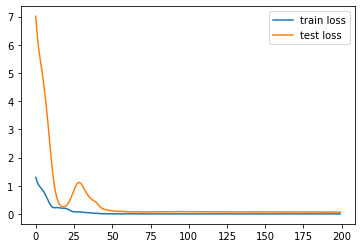

In [9]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

### Wrong Forecasting

In [10]:
validation_predictions,validation_target = wrong_forcasting(Y,N,X_test,model,model_type=model_type,T=T)

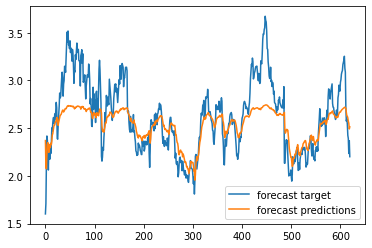

In [11]:
plot_metric(validation_target, "forecast target")
plot_metric(validation_predictions, "forecast predictions")

### Correct forecasting

In [12]:
validation_predictions,validation_target = correct_forcasting(Y,N,X_test,model,model_type=model_type,T=T)

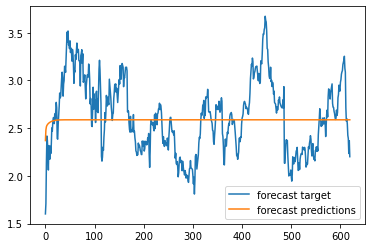

In [13]:
plot_metric(validation_target, "forecast target")
plot_metric(validation_predictions, "forecast predictions")

### Part 2: Returns

In [14]:
df = return_calculator(df,t=1)

In [15]:
df.head()

,date,open,high,low,close,volume,Name,prev_close,return,log_return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004089
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002135
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007672
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005028


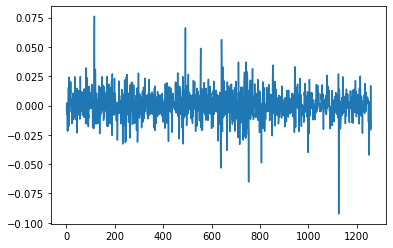

In [16]:
plt.plot(df['return'])

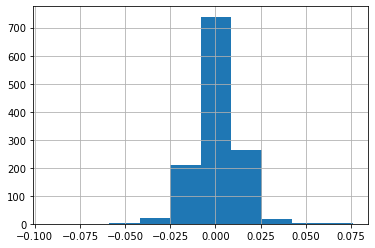

In [17]:
df['return'].hist();

In [18]:
scaler_return, series_return= scale_series(df,mode="return")

In [19]:
X_return,Y_return,N_return = create_dataset(series_return,T)

1238
X.shape (1238, 20, 1) Y.shape (1238, 1)


In [60]:
model_return,train_losses_return, test_losses_return, device, X_test_return, y_test_return = create_model_and_train(X_return,Y_return,T=T,N=N,D=D,M=M,L=L,K=K,n_epochs=200,model_type=model_type)

cpu
Epoch 5/200, Train Loss: 1.0292, Test Loss: 1.0977
Epoch 10/200, Train Loss: 1.0274, Test Loss: 1.1032
Epoch 15/200, Train Loss: 1.0250, Test Loss: 1.1003
Epoch 20/200, Train Loss: 1.0210, Test Loss: 1.1045
Epoch 25/200, Train Loss: 1.0200, Test Loss: 1.1093
Epoch 30/200, Train Loss: 1.0177, Test Loss: 1.1043
Epoch 35/200, Train Loss: 1.0159, Test Loss: 1.1066
Epoch 40/200, Train Loss: 1.0132, Test Loss: 1.1155
Epoch 45/200, Train Loss: 1.0096, Test Loss: 1.1132
Epoch 50/200, Train Loss: 1.0048, Test Loss: 1.1175
Epoch 55/200, Train Loss: 0.9962, Test Loss: 1.1219
Epoch 60/200, Train Loss: 0.9943, Test Loss: 1.1443
Epoch 65/200, Train Loss: 0.9795, Test Loss: 1.1518
Epoch 70/200, Train Loss: 0.9693, Test Loss: 1.1566
Epoch 75/200, Train Loss: 0.9559, Test Loss: 1.1741
Epoch 80/200, Train Loss: 0.9454, Test Loss: 1.1894
Epoch 85/200, Train Loss: 0.9279, Test Loss: 1.2333
Epoch 90/200, Train Loss: 0.9044, Test Loss: 1.2667
Epoch 95/200, Train Loss: 0.8985, Test Loss: 1.2775
Epoch 100

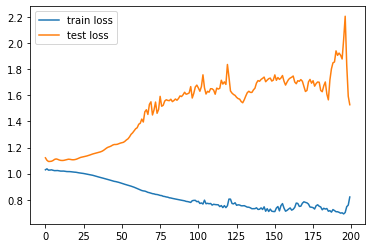

In [21]:
plot_metric(train_losses_return, "train loss")
plot_metric(test_losses_return, "test loss")

### Wrong Forecasting

In [22]:
validation_predictions_return,validation_target_return = wrong_forcasting(Y_return,N,X_test_return,model_return,model_type=model_type,T=T)

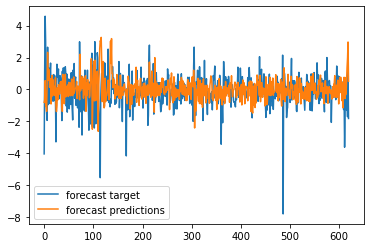

In [23]:
plot_metric(validation_target_return, "forecast target")
plot_metric(validation_predictions_return, "forecast predictions")

### Correct forecasting

In [24]:
validation_predictions_return,validation_target_return = correct_forcasting(Y_return,N,X_test_return,model_return,model_type=model_type,T=T)

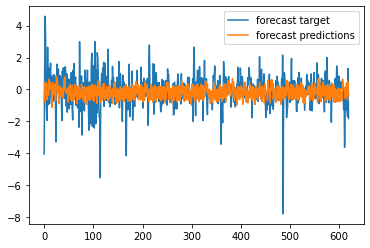

In [25]:
plot_metric(validation_target_return, "forecast target")
plot_metric(validation_predictions_return, "forecast predictions")

### Part 3: Binary Classification

In [33]:
scaler_binary, input_data, Ntrain, N_binary, D_binary, targets = scale_binary(df,T)

In [34]:
X_train_binary, Y_train_binary, X_test_binary, Y_test_binary = create_dataset_binary(Ntrain,T,N_binary,D_binary,input_data,targets)

In [43]:
mode="binary"

In [62]:
model_binary,train_losses_binary, test_losses_binary, device, X_test_binary, y_test_binary, X_train_binary, y_train_binary = create_model_and_train(X_train_binary,Y_train_binary,T=T,N=N_binary,D=D_binary,M=50,L=2,K=1,n_epochs=200,model_type=model_type,mode=mode)

cpu
Epoch 5/200, Train Loss: 0.6918, Test Loss: 0.7015
Epoch 10/200, Train Loss: 0.6907, Test Loss: 0.7417
Epoch 15/200, Train Loss: 0.6869, Test Loss: 0.7136
Epoch 20/200, Train Loss: 0.6801, Test Loss: 0.7617
Epoch 25/200, Train Loss: 0.6750, Test Loss: 0.8304
Epoch 30/200, Train Loss: 0.6638, Test Loss: 1.0124
Epoch 35/200, Train Loss: 0.6460, Test Loss: 0.9758
Epoch 40/200, Train Loss: 0.6199, Test Loss: 1.0430
Epoch 45/200, Train Loss: 0.6071, Test Loss: 1.2405
Epoch 50/200, Train Loss: 0.5702, Test Loss: 1.3922
Epoch 55/200, Train Loss: 0.5319, Test Loss: 1.5855
Epoch 60/200, Train Loss: 0.5011, Test Loss: 1.5786
Epoch 65/200, Train Loss: 0.4681, Test Loss: 1.5538
Epoch 70/200, Train Loss: 0.4330, Test Loss: 1.7987
Epoch 75/200, Train Loss: 0.4424, Test Loss: 1.9914
Epoch 80/200, Train Loss: 0.3637, Test Loss: 2.3521
Epoch 85/200, Train Loss: 0.2990, Test Loss: 2.4641
Epoch 90/200, Train Loss: 0.2760, Test Loss: 2.8057
Epoch 95/200, Train Loss: 0.3316, Test Loss: 2.9158
Epoch 100

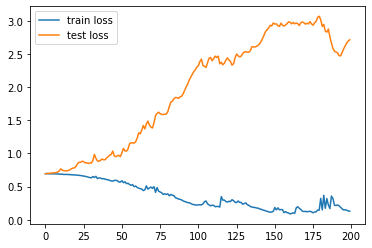

In [42]:
plot_metric(train_losses_binary, "train loss")
plot_metric(test_losses_binary, "test loss")

### Results

In [66]:
acc_compouter(model_binary, X_train_binary, y_train_binary, device)

1.0

In [67]:
acc_compouter(model_binary, X_test_binary, y_test_binary, device)

0.49193548387096775